In [1]:
from gdt.missions.fermi.gbm.catalogs import BurstCatalog

# initialize burst catalog and list number of rows
burstcat = BurstCatalog()
burstcat.num_rows

Sending request and awaiting response from HEASARC...
Finished in 76 s


4190

In [2]:
import numpy as np

cols = np.strings.upper(["T90", "Flux_BATSE_64", "Fluence_BATSE", "Pflx_Comp_Epeak", "Trigger_Time"])
burstcat.get_table(cols)

rec.array([( 4.288,  0.6028, 1.2524e-07, 205.7393 , 56020.856927  ),
           (17.408, 11.1926, 1.3652e-05, 204.6519 , 55984.72547517),
           (11.008,  2.6118, 8.9879e-07, 115.3316 , 60088.35730917), ...,
           ( 7.552, 15.1617, 1.8073e-06, 157.2283 , 55056.17410408),
           ( 8.192,  3.2791, 1.6901e-06, 559.1635 , 55593.39942421),
           (29.184,  1.5475, 2.7596e-06,  81.31714, 59672.86295194)],
          dtype=[('T90', '<f8'), ('FLUX_BATSE_64', '<f8'), ('FLUENCE_BATSE', '<f8'), ('PFLX_COMP_EPEAK', '<f8'), ('TRIGGER_TIME', '<f8')])

In [3]:
cond1 = ("T90"              , 0 , 2)
cond2 = ("Flux_BATSE_64"    , 4 , 10_000) 
cond3 = ("Pflx_Comp_Epeak"  , 50, 10_000)
triggered_table = burstcat.slices(
    [cond2, cond1]#, cond3]
)

times = triggered_table.get_table(columns=("trigger_time", "T90"))
trig_time = times['TRIGGER_TIME']

total_events = len(trig_time)
print(f"Total events: {total_events}")

days_year = 365.25
years = (max(trig_time) - min(trig_time))/days_year
print(f"MET diff {years:.2f} yrs")

event_rate = len(trig_time) / years
print(f"Event rate: {event_rate:.2f} events/yr")

proper_table = triggered_table # small value to guarantee fit has been done
table_to_save = proper_table.get_table(columns=("Flux_BATSE_64", "T90", "Fluence_BATSE", "Pflx_Comp_Epeak"))
ev_rate = len(table_to_save) / years
print(f"Total events with proper fit: {len(table_to_save)}")
print(f"Event rate with proper fit: {ev_rate:.2f} events/yr")

Total events: 323
MET diff 17.45 yrs
Event rate: 18.51 events/yr
Total events with proper fit: 323
Event rate with proper fit: 18.51 events/yr


In [6]:
# prepare data in the order pflx, t90, fluence, epeak and save to .txt file
table_to_save = table_to_save[["FLUX_BATSE_64", "T90", "FLUENCE_BATSE", "PFLX_COMP_EPEAK"]]

ev_rate_string = f"{ev_rate:.2f}".replace(".", "_")

filename = "fermi_catalogue_plim_4_t90_1_rate_" + ev_rate_string + ".txt"

np.savetxt(
    filename,
    table_to_save,
)

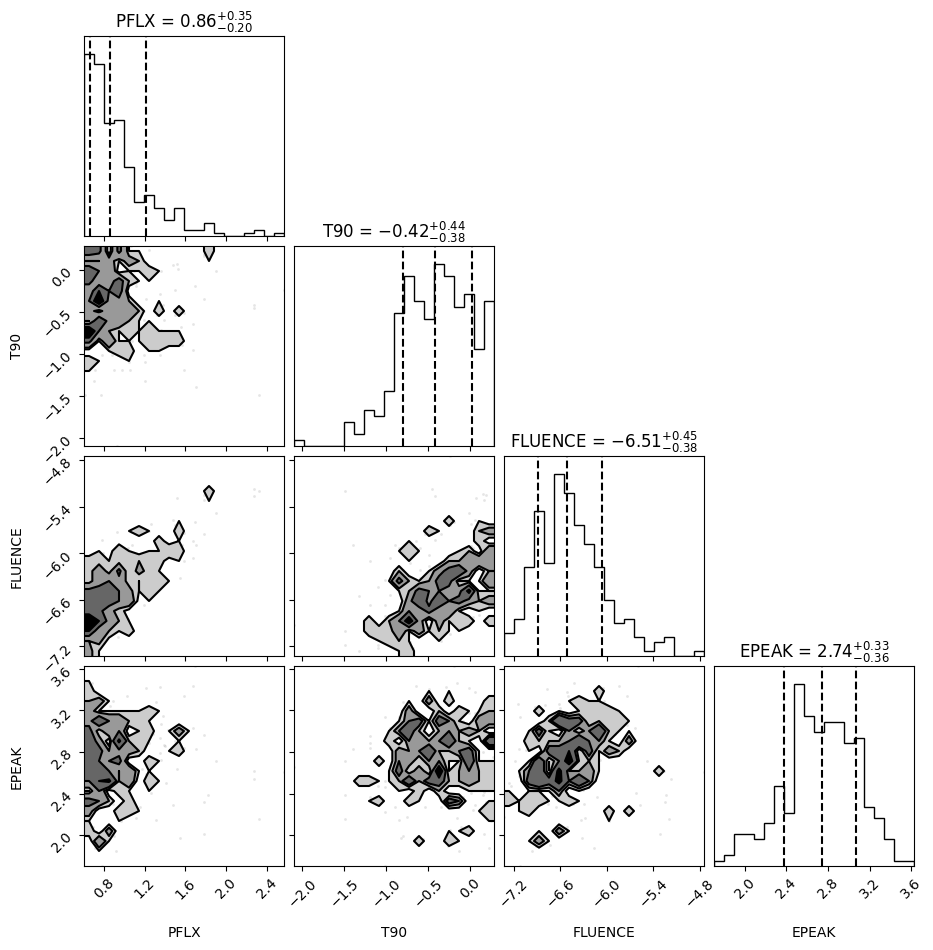

In [7]:
import corner
from matplotlib import pyplot as plt

# load data to check 

loaded_data = np.loadtxt(filename)

pflx    = np.log10(loaded_data[:, 0])
t90     = np.log10(loaded_data[:, 1])
fluence = np.log10(loaded_data[:, 2])
epeak   = np.log10(loaded_data[:, 3])

corner.corner(
    np.array([pflx, t90, fluence, epeak]).T,
    labels=["PFLX", "T90", "FLUENCE", "EPEAK"],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    fill_contours=True,
)
plt.show()

# Table of all short GRBs

In [1]:
import pandas as pd

cond = ("T90", 0, 2)

cut_table = burstcat.slices([cond])
cols = ("Flux_BATSE_64", "T90", "Fluence_BATSE", "Pflx_Comp_Epeak", "TRIGGER_TIME")
all_table = cut_table.get_table(
    columns=cols,
)
#save the rec_array all_table to a file

table_df = pd.DataFrame(all_table)
# to dat
table_df.to_csv("burst_catalog.dat", index=False)
print(f"Saved {len(table_df)} rows to burst_catalog.dat")

NameError: name 'burstcat' is not defined

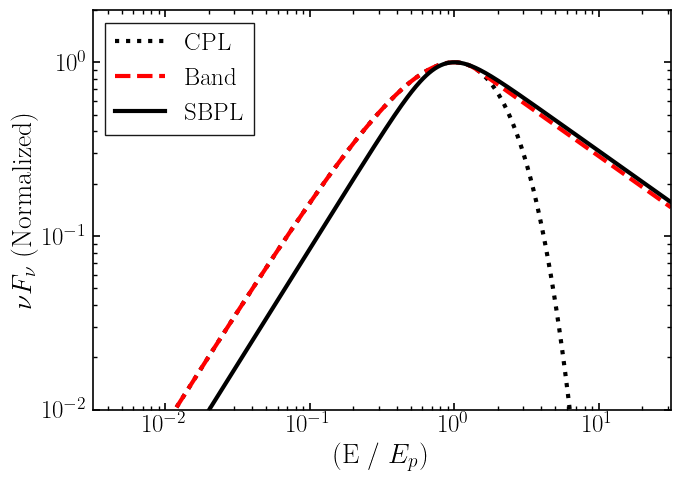

$\alpha$=-0.67, $\beta$=-2.59


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
plt.style.use('../configurations/style.mplstyle')
# --- Spectral Model Definitions (returning shapes proportional to nuFnu = E^2 dN/dE) ---

def band_nuFnu_shape(x, alpha, beta):
    """
    Calculates the Band function nuFnu shape vs x = E/E_peak.
    Normalized to peak at x=1 if alpha and beta are typical.

    Args:
        x (float or np.ndarray): Dimensionless energy E/E_peak.
        alpha (float): Low-energy photon index.
        beta (float): High-energy photon index.

    Returns:
        float or np.ndarray: Shape proportional to nuFnu.
    """
    if 2.0 + alpha <= 0:
        return np.full_like(x, np.nan) # Physical constraint & prevents division by zero

    x = np.asarray(x)
    # Break point in terms of x = E/E_peak
    xc = (alpha - beta) / (2.0 + alpha)

    # Calculate shape (proportional to x^2 * dN/dE(x*E_peak))
    # Low-energy segment shape: x^(2+alpha) * exp(-x * (2+alpha))
    flux_low_shape = np.power(x, 2.0 + alpha) * np.exp(-x * (2.0 + alpha))

    # High-energy segment shape: const * x^(2+beta)
    term_high_const = np.power(xc, alpha - beta) * np.exp(beta - alpha)
    flux_high_shape = term_high_const * np.power(x, 2.0 + beta)

    # Combine using np.where, handling x=0 case
    shape = np.where(x < xc, flux_low_shape, flux_high_shape)
    shape = np.where(x <= 0, 0.0, shape) # Ensure 0 for non-positive x

    # --- Normalization ---
    # Normalize so the function value is 1.0 at the peak (x=1)
    # Evaluate the low-energy part at x=1 (assuming standard alpha/beta where peak is below Ec)
    # This happens if 1 < xc => 1 < (alpha-beta)/(2+alpha) => 2+alpha < alpha-beta => 2 < -beta
    # If beta < -2 (common), the peak is in the low-energy part.
    peak_value = np.power(1.0, 2.0 + alpha) * np.exp(-(2.0 + alpha))
    if peak_value > 1e-100: # Avoid division by zero if peak is exactly zero
         shape = shape / peak_value
    else:
         # Handle cases where peak value is zero or numerical issues arise
         # Maybe normalize by max value instead?
         max_val = np.max(shape)
         if max_val > 1e-100:
             shape = shape / max_val


    return shape

def bpl_nuFnu_shape(x, alpha_bpl, beta_s, n, eps):
    """
    Calculates the Broken Power Law nuFnu shape vs x = E/E_p_bpl.
    Note E_p_bpl corresponds to the definition used with eps, not necessarily the nuFnu peak.

    Args:
        x (float or np.ndarray): Dimensionless energy E / E_p_bpl.
        alpha_bpl, beta_s, n, eps: BPL parameters as defined previously.

    Returns:
        float or np.ndarray: Shape proportional to nuFnu.
    """
    x = np.asarray(x)
    # y = E / E_break = (x * E_p_bpl) / (E_p_bpl / eps) = x * eps
    y = x * eps

    # Original dN/dE shape (arbitrary normalization)
    # Avoid issues with y=0 if x=0
    y_safe = np.maximum(y, 1e-100) # Avoid power(0, negative) issues
    dn_de_shape = (y_safe**(-alpha_bpl * n) + y_safe**(-beta_s * n))**(-1.0 / n)

    # nuFnu shape is proportional to E^2 * dN/dE = (x * E_p_bpl)^2 * dN/dE
    # For shape comparison, just use x^2 * dN/dE shape
    shape = x**2 * dn_de_shape
    shape = np.where(x <= 0, 0.0, shape) # Ensure 0 for non-positive x

    return shape # Return unnormalized shape

def cpl_nuFnu_shape(x, alpha):
    """
    Calculates the Cut-off Power Law nuFnu shape vs x = E/E_peak.
    Normalized to peak at x=1.

    Args:
        x (float or np.ndarray): Dimensionless energy E/E_peak.
        alpha (float): Photon index.

    Returns:
        float or np.ndarray: Shape proportional to nuFnu.
    """
    if 2.0 + alpha <= 0:
         return np.full_like(x, np.nan)

    x = np.asarray(x)
    # nuFnu shape ~ E^2 * E^alpha * exp(-E * (2+alpha)/E_peak)
    #           ~ x^2 * x^alpha * exp(-x * (2+alpha))
    shape = np.power(x, 2.0 + alpha) * np.exp(-x * (2.0 + alpha))
    shape = np.where(x <= 0, 0.0, shape) # Ensure 0 for non-positive x

    # Normalize to peak value (at x=1)
    peak_value = np.power(1.0, 2.0 + alpha) * np.exp(-(2.0 + alpha))
    if peak_value > 1e-100:
        shape = shape / peak_value
    else:
        max_val = np.max(shape)
        if max_val > 1e-100:
            shape = shape / max_val


    return shape

# --- Simulation Parameters ---
# Use same parameters as before, renaming bpl alpha again
alpha_bpl_param = -0.67
beta_s_param = -2.59
n_param = 2
eps_param = (-(2 + alpha_bpl_param)/(2 + beta_s_param))**(1/(n_param*(alpha_bpl_param - beta_s_param)))

# Common spectral indices for Band and CPL for comparison
spec_alpha = -0.67
spec_beta = -2.59 # Used only for Band

# --- Plotting Setup ---
# Define range in terms of x = E/E_peak
x_range = np.logspace(-2.5, 1.5, 400)

# Calculate nuFnu shapes
cpl_shape = cpl_nuFnu_shape(x_range, spec_alpha)
bpl_shape = bpl_nuFnu_shape(x_range, alpha_bpl_param, beta_s_param, n_param, eps_param)
band_shape = band_nuFnu_shape(x_range, spec_alpha, spec_beta)

# Normalize BPL shape for plotting (e.g., match peak height of Band/CPL)
# Find the approximate peak location of the BPL nuFnu shape first
peak_idx_bpl = np.argmax(bpl_shape)
if bpl_shape[peak_idx_bpl] > 1e-100:
    bpl_shape_normalized = bpl_shape / bpl_shape[peak_idx_bpl]
else:
    bpl_shape_normalized = bpl_shape # Avoid division by zero


# --- Create Plot ---
plt.figure(figsize=(7, 5))

plt.plot(x_range, cpl_shape, label=f"CPL", linestyle=':', lw=3, color='k')
plt.plot(x_range, band_shape, label=f"Band", linestyle='--', lw=3, color='red')
plt.plot(x_range, bpl_shape_normalized, label=f"SBPL", color='k', lw=3) 
# --- Plot Styling ---
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"(E / $E_{p}$)", fontsize=20)
plt.ylabel(r"$\nu F_{\nu}$ (Normalized)", fontsize=20)
plt.xlim(x_range.min(), x_range.max())
plt.ylim(1e-2, 2.0) # May need adjustment
plt.legend(fontsize=18)
#ticks size to 18
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig("spectral_models_comparison.pdf", dpi=300)
plt.show()

print(f"$\\alpha$={alpha_bpl_param}, $\\beta$={beta_s_param}")

Found and processing 268 simulated short, bright GRBs...


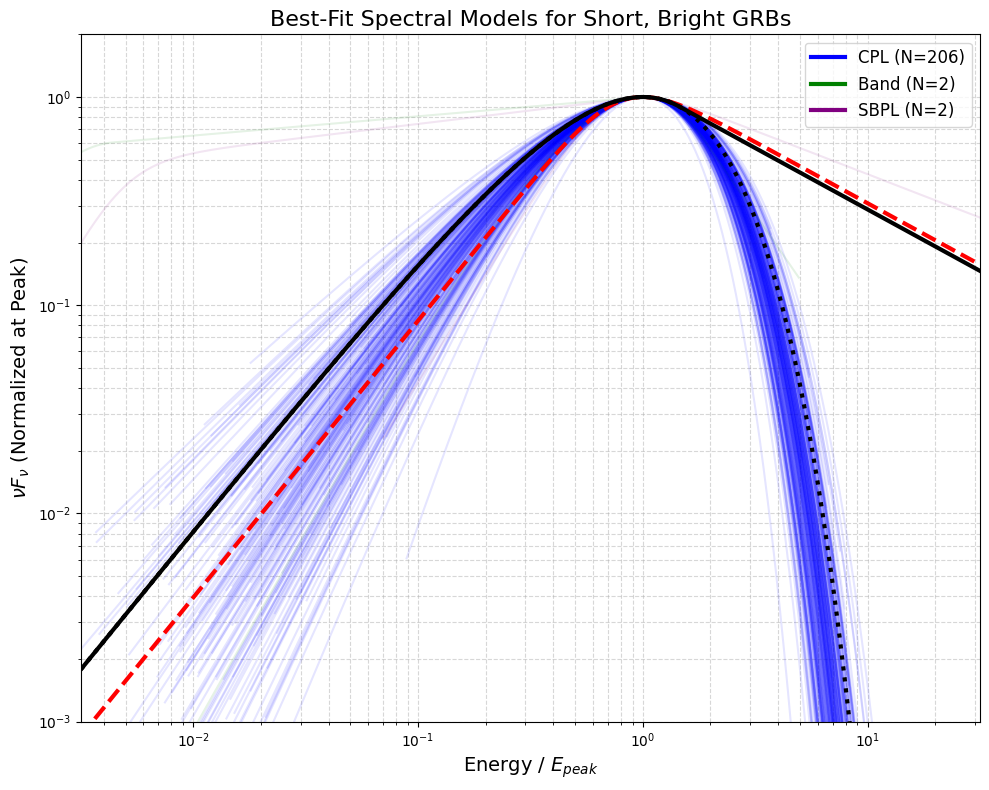

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def cpl_nuFnu_shape(E, E_peak, alpha):
    """Calculates the Cut-off Power Law nuFnu shape."""
    if 2.0 + alpha <= 0:
        return np.full_like(E, np.nan)
    x = E / E_peak
    shape = np.power(x, 2.0 + alpha) * np.exp(-x * (2.0 + alpha))
    return np.where(x <= 0, 0.0, shape)

def band_nuFnu_shape(E, E_peak, alpha, beta):
    """Calculates the Band function nuFnu shape."""
    if 2.0 + alpha <= 0 or alpha <= beta:
        return np.full_like(E, np.nan)
    x = E / E_peak
    xc = (alpha - beta) / (2.0 + alpha)
    flux_low = np.power(x, 2.0 + alpha) * np.exp(-x * (2.0 + alpha))
    const_high = np.power(xc, alpha - beta) * np.exp(beta - alpha)
    flux_high = const_high * np.power(x, 2.0 + beta)
    return np.where(x < xc, flux_low, flux_high)

def sbpl_nuFnu_shape(E, E_break, indx1, indx2):
    """Calculates the Smoothly Broken Power Law nuFnu shape."""
    # The SBPL model has a fixed smoothness parameter in the catalog fits
    n = 2.0
    y = E / E_break
    y_safe = np.maximum(y, 1e-100)
    dn_de_shape = (y_safe ** (-indx1 * n) + y_safe ** (-indx2 * n)) ** (
        -1.0 / n
    )
    # nuFnu shape is proportional to E^2 * dN/dE
    return E**2 * dn_de_shape

# --- Main Script ---
# 1. Define columns to fetch from the catalog
cols_to_get = [
    "Pflx_Best_Fitting_Model",
    "Pflx_Comp_Epeak",
    "Pflx_Comp_Index",
    "Pflx_Band_Epeak",
    "Pflx_Band_Alpha",
    "Pflx_Band_Beta",
    "Pflx_SBPL_Brken",
    "Pflx_SBPL_Indx1",
    "Pflx_SBPL_Indx2",
]

# In your real code, you would use your 'burstcat' object here
# burstcat = YourBurstcatObject(...)
cond1 = ("T90", 0, 2)
cond2 = ("Flux_BATSE_64", 4, 10_000)
cond3 = ("Pflx_Comp_Epeak", 50, 10_000)
triggered_table = burstcat.slices([cond1, cond2, cond3])
data_table = triggered_table.get_table(columns=cols_to_get)

# For demonstration, we use the simulated data
#burstcat = MockBurstcat()
#data_table = burstcat.get_table(columns=cols_to_get)
num_events = len(data_table["PFLX_BEST_FITTING_MODEL"])
print(f"Found and processing {num_events} simulated short, bright GRBs...")

# 2. Process data and calculate spectral shapes
# Define a common energy grid for plotting
E_grid = np.logspace(1, 4, 1000)  # 10 keV to 100 MeV

# Store the results
cpl_fits, band_fits, sbpl_fits = [], [], []

for i in range(num_events):
    model = data_table["PFLX_BEST_FITTING_MODEL"][i].strip()
    #array(['pflx_band                       ',
    #   'pflx_comp                       ',
    #   'pflx_plaw                       ',
    #   'pflx_sbpl                       '], dtype='<U32')
    if model == "pflx_comp":
        E_peak = data_table["PFLX_COMP_EPEAK"][i]
        alpha = data_table["PFLX_COMP_INDEX"][i]
        if E_peak > 0 and not np.isnan(alpha):
            shape = cpl_nuFnu_shape(E_grid, E_peak, alpha)
            cpl_fits.append(shape)

    elif model == "pflx_band":
        E_peak = data_table["PFLX_BAND_EPEAK"][i]
        alpha = data_table["PFLX_BAND_ALPHA"][i]
        beta = data_table["PFLX_BAND_BETA"][i]
        if E_peak > 0 and not np.isnan([alpha, beta]).any():
            shape = band_nuFnu_shape(E_grid, E_peak, alpha, beta)
            band_fits.append(shape)

    elif model == "pflx_sbpl":
        E_break = data_table["PFLX_SBPL_BRKEN"][i]
        indx1 = data_table["PFLX_SBPL_INDX1"][i]
        indx2 = data_table["PFLX_SBPL_INDX2"][i]
        if E_break > 0 and not np.isnan([indx1, indx2]).any():
            shape = sbpl_nuFnu_shape(E_grid, E_break, indx1, indx2)
            sbpl_fits.append(shape)

# 3. Create the Plot
plt.figure(figsize=(10, 8))
ax = plt.gca()

# Plot individual fits with transparency
for model_fits, color in [
    (cpl_fits, "blue"),
    (band_fits, "green"),
    (sbpl_fits, "purple"),
]:
    for shape in model_fits:
        # Normalize each shape to have a peak of 1 for plotting
        peak_val = np.nanmax(shape)
        if peak_val > 1e-9:
            norm_shape = shape / peak_val
            # Find E_peak to normalize the x-axis
            E_peak_val = E_grid[np.nanargmax(shape)]
            ax.plot(E_grid / E_peak_val, norm_shape, color=color, alpha=0.1)

# Calculate and plot the median of the normalized fits
legend_elements = []
for model_fits, color, label in [
    (cpl_fits, "blue", "CPL"),
    (band_fits, "green", "Band"),
    (sbpl_fits, "purple", "SBPL"),
]:
    if len(model_fits) > 0:
        legend_elements.append(
            Line2D(
                [0], [0], color=color, lw=3,
                label=f"{label} (N={len(model_fits)})"
            )
        )

# --- Plot Styling ---
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"Energy / $E_{peak}$", fontsize=14)
ax.set_ylabel(r"$\nu F_{\nu}$ (Normalized at Peak)", fontsize=14)
ax.set_title(
    "Best-Fit Spectral Models for Short, Bright GRBs", fontsize=16
)
ax.set_xlim(x_range.min(), x_range.max())
ax.set_ylim(1e-3, 2.0)
ax.grid(True, which="both", ls="--", alpha=0.5)

ax.plot(x_range, bpl_shape_normalized, label=f"SBPL", linestyle='--', lw=3, color='red')
ax.plot(x_range, cpl_shape, label=f"CPL", linestyle=':', lw=3, color='k')
ax.plot(x_range, band_shape, label=f"Band", color='k', lw=3)

ax.legend(handles=legend_elements, fontsize=12)
plt.tight_layout()
plt.show()